In [1]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import os
os.sys.path.extend(['../evaluation'])
from evaluate import model_preprocessed_filepath
import glob
from matplotlib import pyplot as plt
import math
%matplotlib inline

chencherry = SmoothingFunction().method2

In [2]:
def get_scores(filepath, set_='test', subset='old-cat'):
    
    references_files = [f'../evaluation/references/{set_}/{subset}_reference{i}.lex' for i in range(3)]
    hypothesis_file = filepath

    scores = []
    hypothesis = []
    references = []

    with open(references_files[0], 'r', encoding='utf-8') as ref0,\
         open(references_files[1], 'r', encoding='utf-8') as ref1,\
         open(references_files[2], 'r', encoding='utf-8') as ref2,\
         open(hypothesis_file, 'r', encoding='utf-8') as hyp:


        for h, r0, r1, r2 in zip(hyp, ref0, ref1, ref2):

            references.append((r0[:-1], r1[:-1], r2[:-1]))
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([r.split() for r in refs], 
                              hyp.split(), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores, hypothesis, references
    

def plot_hist_bleu(filepath, ax, subset='all-cat'):

    scores, _, _ = get_scores(filepath, 'test', subset)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)

In [3]:
def plot_all_models_hist_bleu(subset):
    
    models = [os.path.basename(s) for s in glob.glob('../data/models/test/*')]

    n_models = len(models)
    n_columns = 3
    n_rows = math.ceil(n_models / 3)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        try:
            filepath = model_preprocessed_filepath(model, 'test', subset)
        except FileNotFoundError as e:
            pass

        plot_hist_bleu(filepath, ax, subset)
        ax.set_title(model)

In [ ]:
plot_all_models_hist_bleu('old-cat')

# Menores scores

In [23]:
models = ['abe2', 'adaptcentre', 'BIU_Chimera_v1']

sc = {}
hyps = {}

for model in models:
    
    scores, hypothesis, _ = get_scores(model_preprocessed_filepath(model, 'test', 'old-cat'))
    
    sc[f'{model}_bleu'] = scores
    hyps[f'{model}_hyp'] = hypothesis
    
data = {}
data.update(sc)
data.update(hyps)

In [24]:
import pandas as pd

pd.set_option('display.max_colwidth', 1000)

df = pd.DataFrame(data)

scores_cols = list(sc.keys())

df['mean_bleu'] = df[scores_cols].mean(axis=1)
df['min_bleu'] = df[scores_cols].min(axis=1)
df['max_bleu'] = df[scores_cols].max(axis=1)
df['range_bleu'] = df['max_bleu'] - df['min_bleu']
df['abe2_to_max'] = df['max_bleu'] - df['abe2_bleu']

In [14]:
df[df.abe2_to_max > 0.5].sample(3)

,abe2_bleu,adaptcentre_bleu,BIU_Chimera_v1_bleu,abe2_hyp,adaptcentre_hyp,BIU_Chimera_v1_hyp,mean_bleu,min_bleu,max_bleu,range_bleu,abe2_to_max
33,0.361328,0.555524,1.000000,sardar ayaz sadiq is the leader of the country .,sardar ayaz sadiq is the leader of pakistan .,the leader of pakistan is sardar ayaz sadiq .,0.638951,0.361328,1.0,0.638672,0.638672
215,0.335689,1.000000,0.262691,the malay are an ethnic group from malaysia .,malaysian malay is an ethnic group in malaysia .,malaysia ' s ethnic group is malaysian malay .,0.532793,0.262691,1.0,0.737309,0.664311
157,0.289978,1.000000,1.000000,"northbrook , illinois is the birthplace of scott adsit .","scott adsit was born in northbrook , illinois .","scott adsit was born in northbrook , illinois .",0.763326,0.289978,1.0,0.710022,0.710022


In [26]:
df.iloc[[969], :]

,abe2_bleu,adaptcentre_bleu,BIU_Chimera_v1_bleu,abe2_hyp,adaptcentre_hyp,BIU_Chimera_v1_hyp,mean_bleu,min_bleu,max_bleu,range_bleu,abe2_to_max
969,0.365607,0.498232,0.51427,william anders was born in british hong kong . william anders was a national of the united states . william anders served as a crew member on apollo 8 . apollo 8 was operated by nasa . buzz aldrin was a backup pilot on the mission with frank borman as a crewman . william anders retired in 1969 - 09 - 01 .,"american william anders was born in british hong kong . he was a crew member of the nasa operated apollo 8 along with buzz aldrin and frank borman . william anders retired on september 1st , 1969 .","william anders was a crew member of apollo 8 operated by nasa . william anders is an united states citizen born in british hong kong . william anders retired on september 01st , 1969 . apollo 8 ' s backup pilot was buzz aldrin and frank borman .",0.45937,0.365607,0.51427,0.148663,0.148663


# Avaliando com textos gerados pelo template

In [3]:
import pickle

with open('../data/models/abe-2/milhoes_de_textos', 'rb') as f:
    references = pickle.load(f)

In [4]:
import re

c = re.compile(r'\W')

In [12]:
def get_scores(filepath):
    
    hypothesis_file = filepath

    scores = []
    hypothesis = []

    with open(hypothesis_file, 'r', encoding='utf-8') as hyp:

        for h in hyp:
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([c.split(r) for r in refs], 
                              c.split(hyp), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores
    

def plot_hist_bleu(filepath, ax):

    scores = get_scores(filepath)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)
    
def plot_all_models_hist_bleu(subset):
    
    models = [os.path.basename(s) for s in glob.glob('../data/models/*')]

    n_models = len(models)
    n_columns = 3
    n_rows = math.ceil(n_models / 3)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        filepath = model_preprocessed_filepath(model, subset)

        plot_hist_bleu(filepath, ax)
        ax.set_title(model)

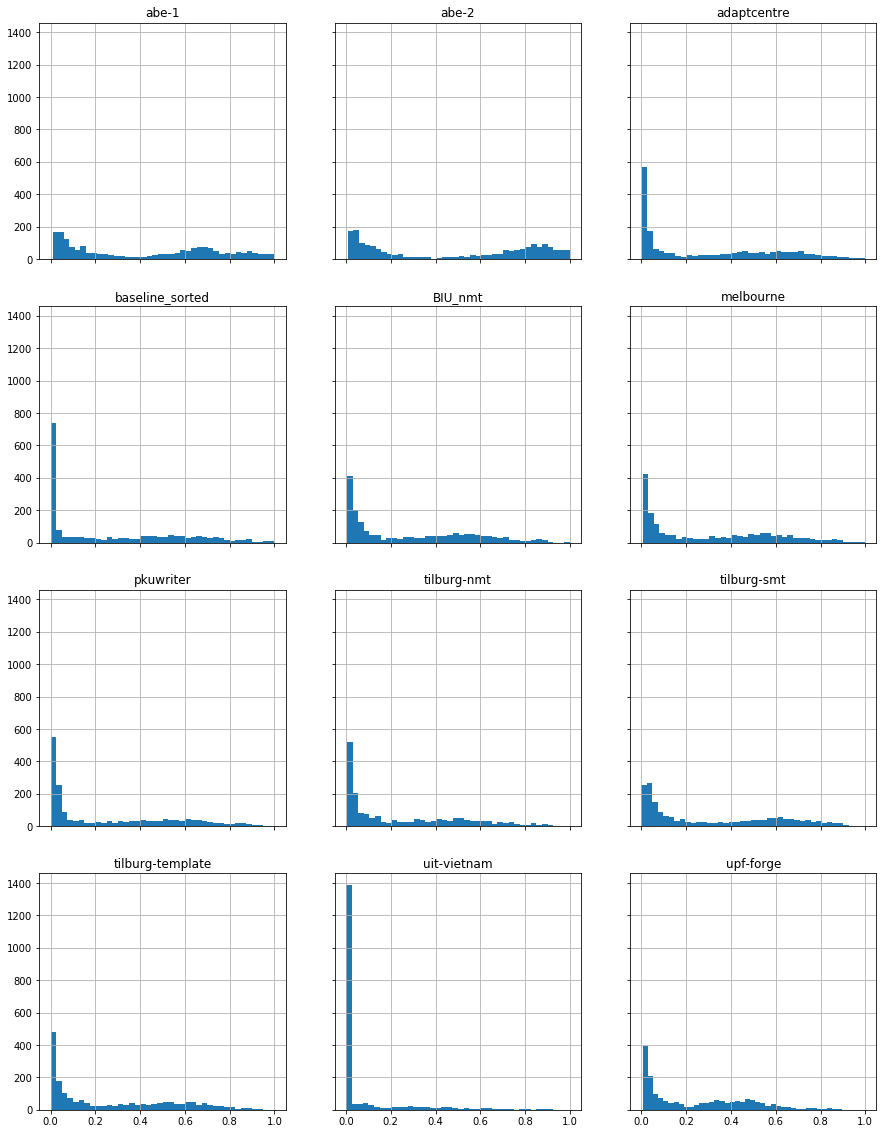

In [16]:
plot_all_models_hist_bleu('all-cat')